# ECSE 415
## Assignment 2
### Abbas Yadollahi - 260680343

## 2. Image Stitching

### 2.1. Coding Questions

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read original hill images (in RGB)
hill1 = cv2.cvtColor(cv2.imread('./stitching_images/1Hill.JPG'), cv2.COLOR_BGR2RGB)
hill2 = cv2.cvtColor(cv2.imread('./stitching_images/2Hill.JPG'), cv2.COLOR_BGR2RGB)
hill3 = cv2.cvtColor(cv2.imread('./stitching_images/3Hill.JPG'), cv2.COLOR_BGR2RGB)

h1, w1, _ = hill1.shape
h2, w2, _ = hill2.shape
h3, w3, _ = hill3.shape

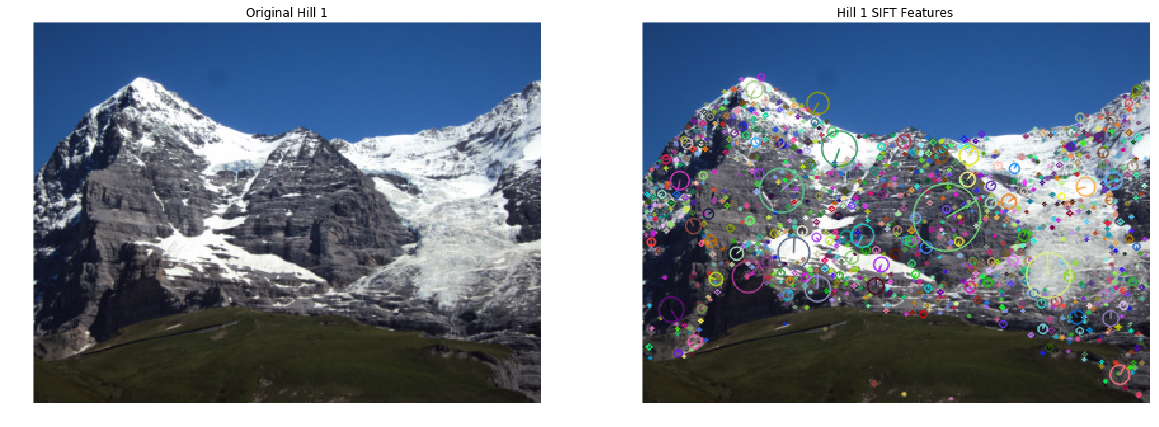

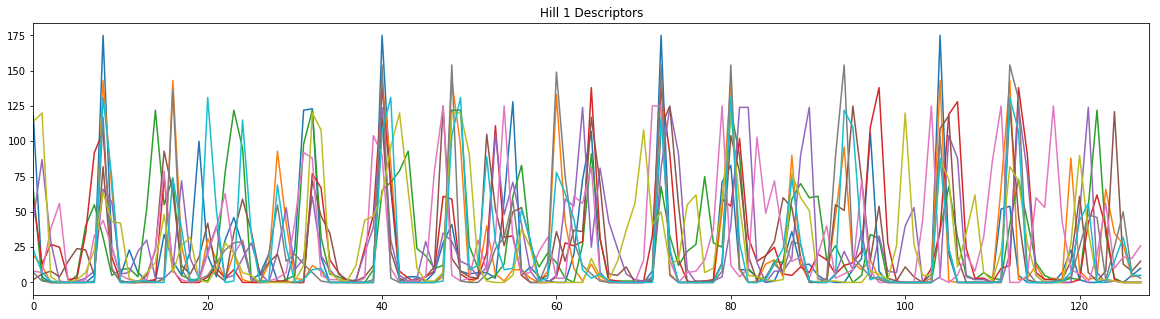

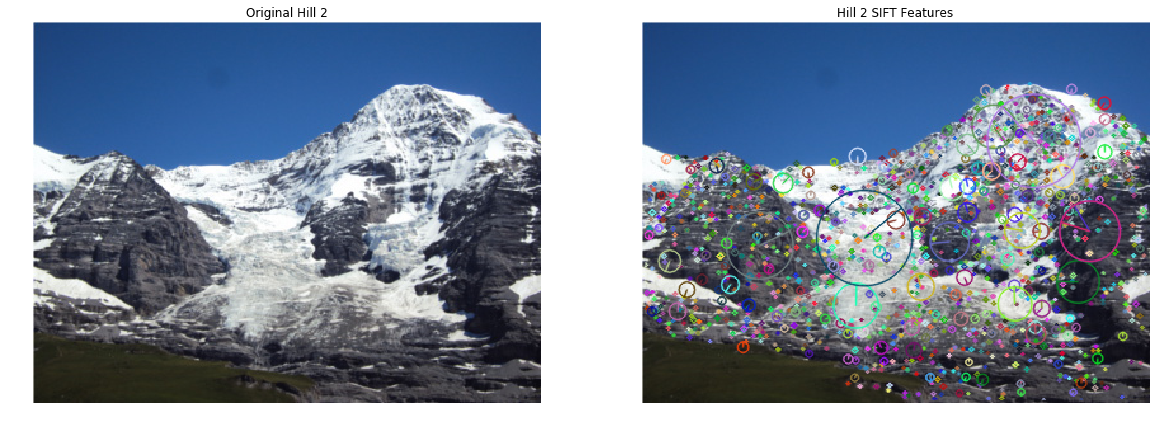

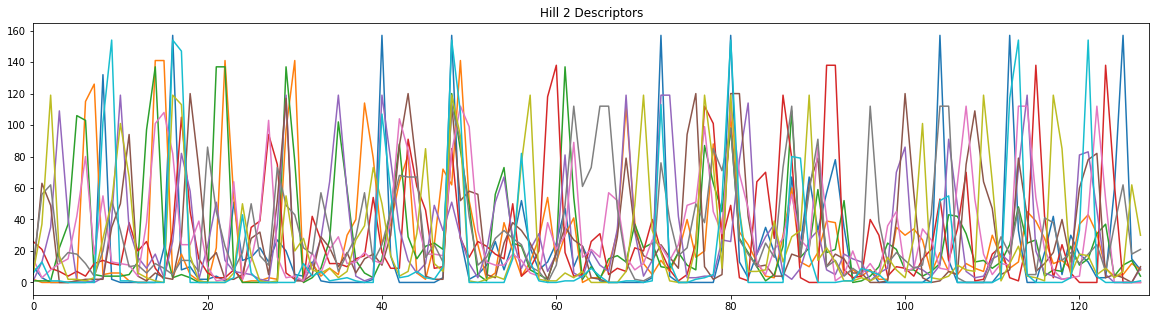

In [3]:
# Create hill1 and hill2 copies
hill1_sift = hill1.copy()
hill2_sift = hill1.copy()

# Detect SIFT features and compute its descriptors
sift = cv2.xfeatures2d.SIFT_create()
hill1_kp, hill1_desc = sift.detectAndCompute(hill1, None)
hill2_kp, hill2_desc = sift.detectAndCompute(hill2, None)

# Draw the keypoints on the hill copies
kp_flag = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
cv2.drawKeypoints(hill1, hill1_kp, hill1_sift, flags=kp_flag)
cv2.drawKeypoints(hill2, hill2_kp, hill2_sift, flags=kp_flag)

# Display hill1 SIFT features and descriptors plot
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(hill1)
plt.title('Original Hill 1'), plt.axis('off')
plt.subplot(122), plt.imshow(hill1_sift)
plt.title('Hill 1 SIFT Features'), plt.axis('off')
plt.show()

plt.figure(figsize=(20, 5))
[plt.plot(hill1_desc[i]) for i in range(10)]
plt.title('Hill 1 Descriptors'), plt.xlim([0, hill1_desc.shape[1]])
plt.show()

# Display hill2 SIFT features and descriptors plot
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(hill2)
plt.title('Original Hill 2'), plt.axis('off')
plt.subplot(122), plt.imshow(hill2_sift)
plt.title('Hill 2 SIFT Features'), plt.axis('off')
plt.show()

plt.figure(figsize=(20, 5))
[plt.plot(hill2_desc[i]) for i in range(10)]
plt.title('Hill 2 Descriptors'), plt.xlim([0, hill2_desc.shape[1]])
plt.show()

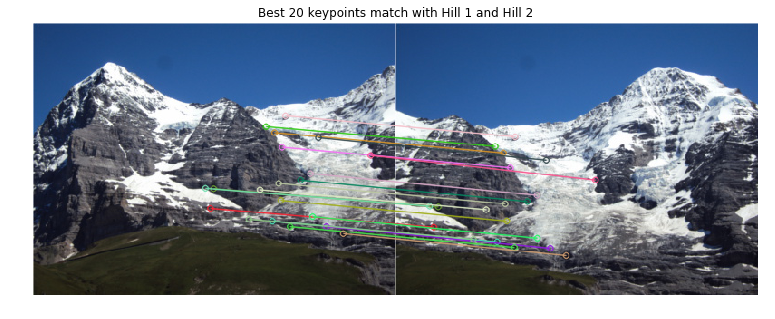

In [4]:
# Find the 20 best keypoint matches between hill1 and hill2
matches = cv2.BFMatcher().match(hill1_desc, hill2_desc)
matches = sorted(matches, key=lambda m: m.distance)
matches_plot = cv2.drawMatches(hill1, hill1_kp, hill2, hill2_kp, matches[:20], hill1, flags=2)

# Display the keypoints matches
plt.figure(figsize=(20, 5))
plt.imshow(matches_plot)
plt.title('Best 20 keypoints match with Hill 1 and Hill 2'), plt.axis('off')
plt.show()

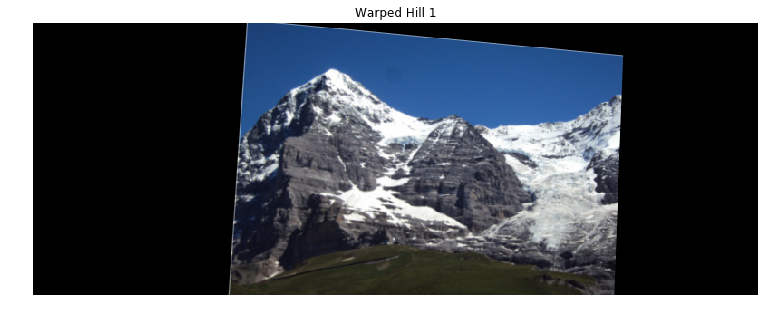

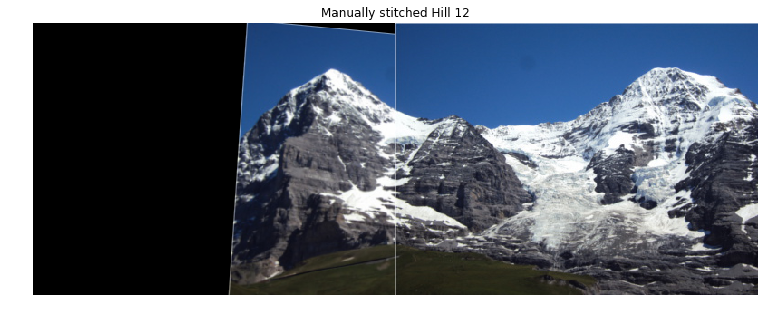

In [5]:
# Seperate left and right matching keypoints
kp_matches = [(m.trainIdx, m.queryIdx) for i, m in enumerate(matches)]

kp_l = np.float32([hill1_kp[i].pt for (_, i) in kp_matches])
kp_r = np.float32([hill2_kp[i].pt for (i, _) in kp_matches])

# Shift keypoints of hill1 to border of hill2
for i in range(len(kp_r)):
    kp_r[i][0] += w2

# Find RANSAC homography and warped hill1
homo, _ = cv2.findHomography(kp_l, kp_r, cv2.RANSAC, 5)
warp = cv2.warpPerspective(hill1, homo, (w1+w2, h1))

# Display warped hill1
plt.figure(figsize=(20, 5))
plt.imshow(warp)
plt.title('Warped Hill 1'), plt.axis('off')
plt.show()

# Overwrite right part of warped hill1 using hill2
hill12_manual = warp.copy()
hill12_manual[:, w2:, :] = hill2

# Display manually stitched hill12
plt.figure(figsize=(20, 5))
plt.imshow(hill12_manual)
plt.title('Manually stitched Hill 12'), plt.axis('off')
plt.show()

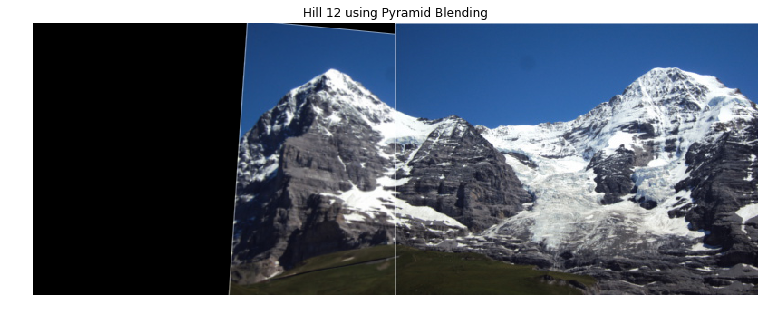

In [6]:
def pyramid_blend(A, B, levels):
    """
    Laplacian pyramid blending.
    :param A: Left image
    :param B: Right image
    :param levels: Depth of pyramid
    """

    # Generate Gaussian pyramid for A and B
    gp_A = [A.copy()]
    gp_B = [B.copy()]
    for i in range(levels):
        gp_A.append(cv2.pyrDown(gp_A[-1]))
        gp_B.append(cv2.pyrDown(gp_B[-1]))

    # Generate Laplacian Pyramids for A and B
    # The bottom of the Laplacian Pyramid holds smallest Gaussian level
    lp_A  = [gp_A[levels-1]]
    lp_B  = [gp_B[levels-1]]
    for i in range(levels-1, 0, -1):
        # Substract upscaled version of lower level from current level to get the high frequencies
        hA, wA, _ = gp_A[i-1].shape
        hB, wB, _ = gp_B[i-1].shape
        lp_A.append(cv2.subtract(gp_A[i-1], cv2.pyrUp(gp_A[i], dstsize=(wA, hA))))
        lp_B.append(cv2.subtract(gp_B[i-1], cv2.pyrUp(gp_B[i], dstsize=(wB, hB))))

    # Blend images at each level
    LS = []
    for la, lb in zip(lp_A, lp_B):
        ls = np.hstack((la, lb))
        LS.append(ls)

    # Reconstruct stitched image
    blend = LS[0]
    for i in range(1, levels):
        h, w, _ = LS[i].shape
        blend = cv2.pyrUp(blend, dstsize=(w, h))
        blend = cv2.add(blend, LS[i])

    return blend.astype(np.uint8)

# Stitch warped hill1 and hill2 using pyramid blending
img_A = warp[:, :w1]
img_B = hill2
hill12 = pyramid_blend(img_A, img_B, 1)
h12, w12, _ = hill12.shape

# Display hill12
plt.figure(figsize=(20,5))
plt.imshow(hill12)
plt.title('Hill 12 using Pyramid Blending'), plt.axis('off')
plt.show()

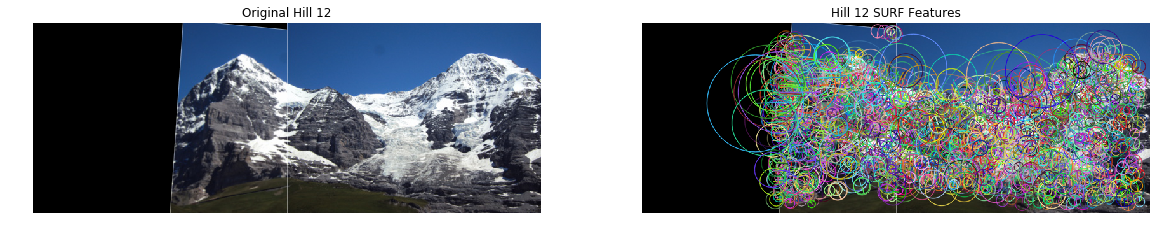

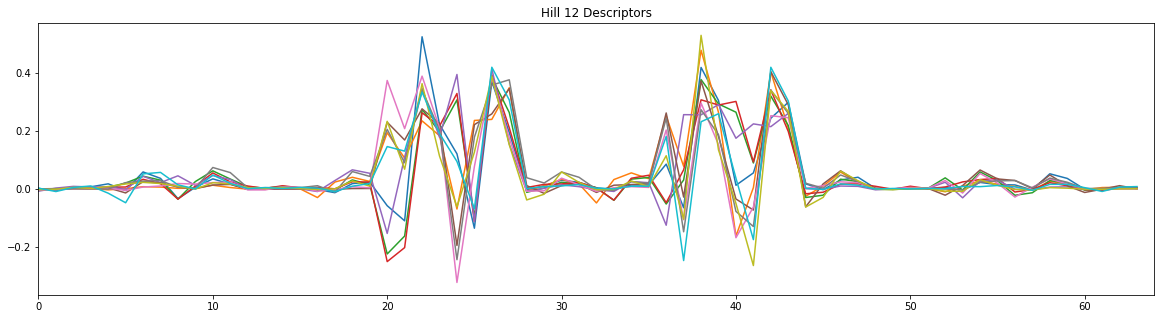

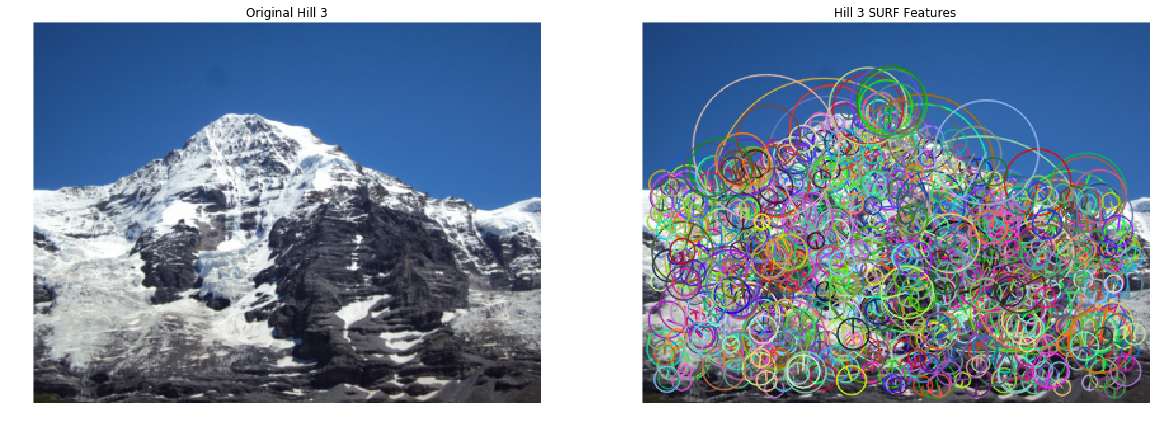

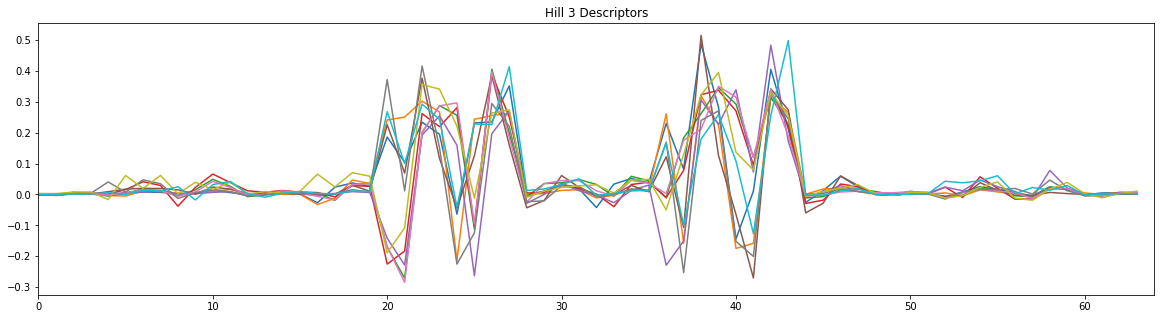

In [7]:
# Create hill12 and hill3 copies
hill12_surf = hill12.copy()
hill3_surf = hill3.copy()

# Detect SIFT features and compute its descriptors
surf = cv2.xfeatures2d.SURF_create()
hill12_kp, hill12_desc = surf.detectAndCompute(hill12, None)
hill3_kp, hill3_desc = surf.detectAndCompute(hill3, None)

# Draw the keypoints on the hill copies
kp_flag = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
cv2.drawKeypoints(hill12, hill12_kp, hill12_surf, flags=kp_flag)
cv2.drawKeypoints(hill3, hill3_kp, hill3_surf, flags=kp_flag)

# Display hill12 SURF features and descriptors plot
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(hill12)
plt.title('Original Hill 12'), plt.axis('off')
plt.subplot(122), plt.imshow(hill12_surf)
plt.title('Hill 12 SURF Features'), plt.axis('off')
plt.show()

plt.figure(figsize=(20, 5))
[plt.plot(hill12_desc[i]) for i in range(10)]
plt.title('Hill 12 Descriptors'), plt.xlim([0, hill12_desc.shape[1]])
plt.show()

# Display hill3 SURF features and descriptors plot
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(hill3)
plt.title('Original Hill 3'), plt.axis('off')
plt.subplot(122), plt.imshow(hill3_surf)
plt.title('Hill 3 SURF Features'), plt.axis('off')
plt.show()

plt.figure(figsize=(20, 5))
[plt.plot(hill3_desc[i]) for i in range(10)]
plt.title('Hill 3 Descriptors'), plt.xlim([0, hill3_desc.shape[1]])
plt.show()

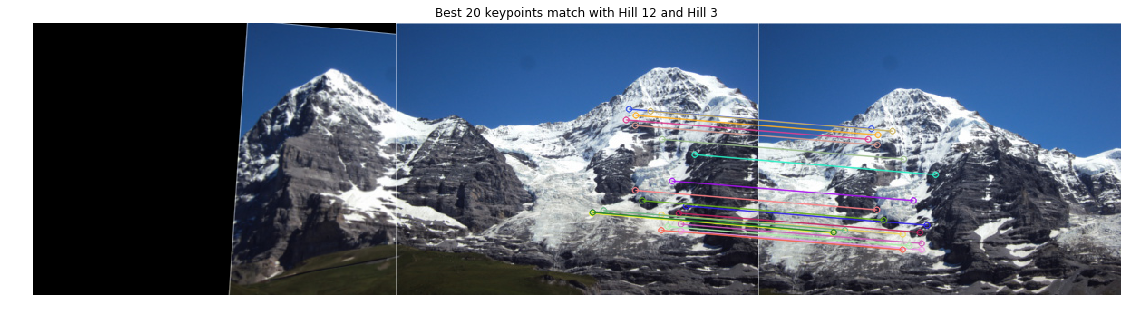

In [8]:
# Find the 20 best keypoint matches between hill12 and hill3
matches = cv2.BFMatcher().match(hill12_desc, hill3_desc)
matches = sorted(matches, key=lambda m: m.distance)
matches_plot = cv2.drawMatches(hill12, hill12_kp, hill3, hill3_kp, matches[:20], hill12, flags=2)

# Display the keypoints matches
plt.figure(figsize=(20, 5))
plt.imshow(matches_plot)
plt.title('Best 20 keypoints match with Hill 12 and Hill 3'), plt.axis('off')
plt.show()

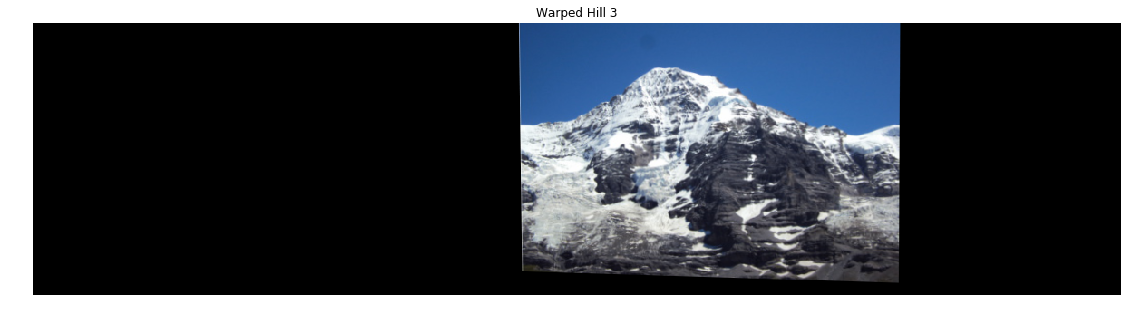

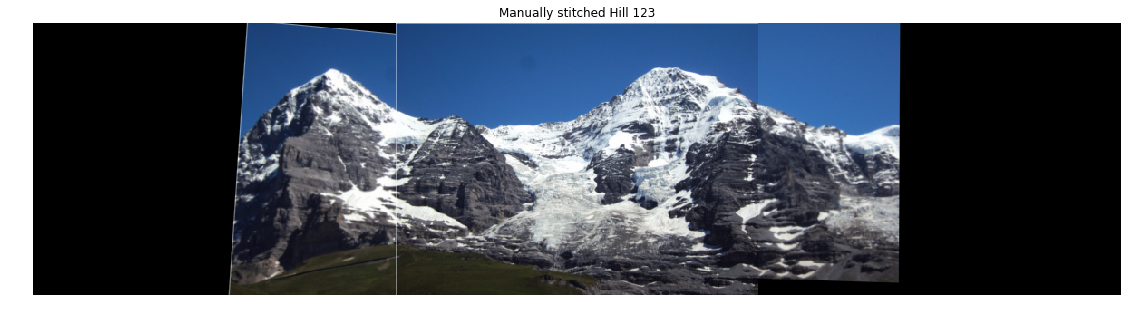

In [9]:
# Seperate left and right matching keypoints
kp_matches = [(m.trainIdx, m.queryIdx) for i, m in enumerate(matches)]

kp_l = np.float32([hill12_kp[i].pt for (_, i) in kp_matches])
kp_r = np.float32([hill3_kp[i].pt for (i, _) in kp_matches])

# Find RANSAC homography and warped hill3
homo, _ = cv2.findHomography(kp_r, kp_l, cv2.RANSAC, 5)
warp = cv2.warpPerspective(hill3, homo, (w12+w3, h3))

# Display warped hill3
plt.figure(figsize=(20, 5))
plt.imshow(warp)
plt.title('Warped Hill 3'), plt.axis('off')
plt.show()

# Overwrite right part of warped hill1 using hill2
hill123_manual = warp.copy()
hill123_manual[:, :w12, :] = hill12

# Display manually stitched hill123
plt.figure(figsize=(20, 5))
plt.imshow(hill123_manual)
plt.title('Manually stitched Hill 123'), plt.axis('off')
plt.show()

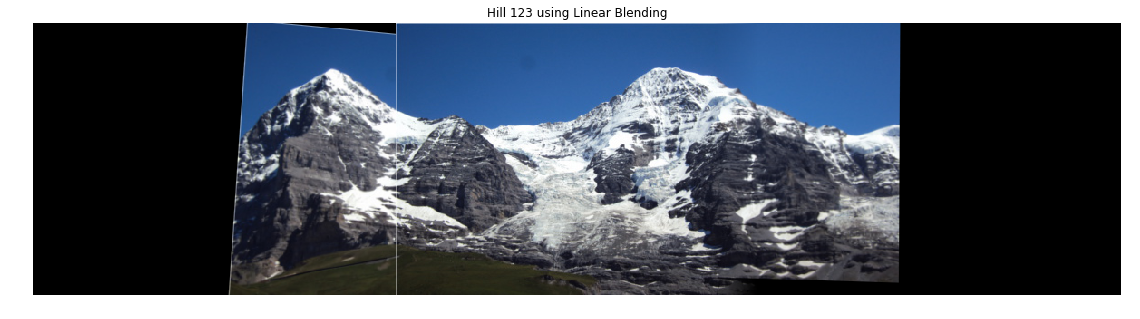

In [10]:
def linear_blend(i_w, r_w, r_idx, s, e):
    """
    Linear blending function.
    :param i_w: Image width
    :param r_w: Ramp width
    :param r_idx: Center ramp index
    :param s: Starting ramp value
    :param e: Ending ramp value
    """

    res = np.zeros(i_w).astype(np.float)
    step = (e - s) / (r_w - 1)
    
    # Start feathering out in incremental steps
    idx = r_idx - r_w
    for i in range(r_w):
        res[idx] = s + step * i
        idx += 1
    res[idx:] = 1
    return res


# Stitch hill12 and warped hill3 using linear blending
img_A = np.zeros((h12, w12 + w3, 3)).astype(np.uint8)
img_A[:, :w12, :] = hill12
img_B = warp
alpha = linear_blend(img_A.shape[1], 50, w12, 0, 1)

# Blend hill12 and warped hill3
hill123 = (1-alpha.reshape(1,-1,1)) * img_A + alpha.reshape(1,-1,1) * warp
hill123 = np.uint8(hill123)

h123, w123, _ = hill123.shape

# Display hill123
plt.figure(figsize=(20,5))
plt.imshow(hill123)
plt.title('Hill 123 using Linear Blending'), plt.axis('off')
plt.show()

### 2.2. Reasoning Questions

1.
SURF is generally much faster than SIFT since it uses box filtering with  integral operations whereas SIFT computes an image pyramid by convolving the image several times with large Gaussian kernels. Although, SURF uses Fast-Hessian matrix to find the points of interests instead of seperating it into 2 operations which makes it a lot less robust than SIFT. As a result, we can see that using SIFT detects a magnitude higher of keypoints than SURF, which can be seen when comparing Hill 1 SURF () vs HILL 1 SIFT (). The number of keypoints using SIFT is much denser than SURF.

In [11]:
sift = cv2.xfeatures2d.SIFT_create()
h1_kp_sift, _ = sift.detectAndCompute(hill1, None)

surf = cv2.xfeatures2d.SURF_create()
h1_kp_surf, _ = surf.detectAndCompute(hill1, None)

print('SIFT Keypoints: ', len(h1_kp_sift))
print('SURF Keypoints: ', len(h1_kp_surf))

SIFT Keypoints:  1254
SURF Keypoints:  896


2.
- Pyramid Blending
  - Pros:
    - Allows the images to blend at different frequency levels
    - Removes ghost more efficiently
  - Cons:
    - Computationally heavy

- Linear Blending:
  - Pros:
    - Simplicity of the algorithm
  - Cons:
    - Hard to balance between low frequency exposure variations and retaining sharp transitions
    - Does not work with all frequency ranges

Pyramid blending would be a better candidate with low frequency images since it is stronger with low frequency levels.

3.
The first image's perspective of the second image will be off since the matching keypoints won't represent any real similarities. As a result, the warping of the second image will be random which makes the final result of the stitching even worse.

4.
What is important when it comes to finding homography between 2 images isn't the number of matching keypoints, but the strength of the matches since it will indicate a less random match. Realistically, we look for a middle ground where there are enough keypoints without causing excess noise, while also having strong matches which will give a more accurate homography.